# Bragg grating filter with phase change material

A waveguide Bragg grating filter is a photonic device that reflects specific wavelengths of light using periodic variations along a waveguide. It’s commonly used in optical communications and sensing for its compact size and precise wavelength selectivity. In the work `Boshu Sun, Maoliang Wei, Kunhao Lei, Zequn Chen, Chunlei Sun, Junying Li, Lan Li, and Hongtao Lin, "Integrated Bragg grating filters based on silicon-Sb2Se3 with non-volatile bandgap engineering capability," Opt. Express 31, 27905-27913 (2023)` [DOI: 10.1364/OE.495196](https://doi.org/10.1364/OE.495196), a compact and low-loss reconfigurable Bragg grating filter using phase change material Sb₂Se₃ on silicon is demonstrated. With a footprint of 0.5 µm × 43.5 µm and >30 dB extinction ratio, it enables efficient switching without static power, ideal for scalable photonic systems.

In this notebook, we design a Bragg grating filter using both FDTD and EME methods. While 3D FDTD offers fully rigorous simulations, it can become computationally expensive for long waveguide gratings. In contrast, EME efficiently handles periodic structures analytically, enabling fast and cost-effective simulations. We compare results from FDTD and EME to validate the accuracy and reliability of the EME approach.

<img src="img/periodic_eme_grating.png" width="400" alt="Schematic of the Bragg grating filter.">

In [1]:
import numpy as np
import tidy3d as td
import tidy3d.web as web
from matplotlib import pyplot as plt

## Simulation Setup

We focus on the wavelength range from 1450 nm to 1550 nm. The goal is to design the waveguide Bragg grating to have the stop band at around 1500 nm.

In [2]:
lda0 = 1.5  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.55, 100)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

The filtering band can be tuned by changing the Sb₂Se₃ between the crystalline phase and the amorphous phase. Crystalline Sb₂Se₃ has a refractive index of 4.16, while the amorphous Sb₂Se₃ has a refractive index of 3.32. The waveguide is made of silicon on oxide. In this case, we model all mediums as nondispersive since the dispersion within the wavelength range of interest is relatively weak. They can be modeled as dispersive mediums if needed. 

In [3]:
n_aSb2Se3 = 3.32  # refractive index of amorphous Sb₂Se₃
n_cSb2Se3 = 4.16  # refractive index of crystalline Sb₂Se₃
n_Si = 3.47  # refractive index of silicon
n_SiO2 = 1.44  # refractive index of oxide

# define the mediums
medium_aSb2Se3 = td.Medium(permittivity=n_aSb2Se3**2)
medium_cSb2Se3 = td.Medium(permittivity=n_cSb2Se3**2)
medium_Si = td.Medium(permittivity=n_Si**2)
medium_SiO2 = td.Medium(permittivity=n_SiO2**2)

The waveguide Bragg grating design is a silicon rib waveguide with periodic Sb₂Se₃ blocks on top. For the target Bragg wavelength of 1550 nm, we can calculate the appropriate grating period by the Bragg condition

$$ 
\lambda_B = 2pn_{eff},
$$

where $p$ is the grating period, $n_{eff} = ff*n_{SOI-SbSe} + (1-ff)*n_{SOI} $, $ff$ is the filling fraction, $n_{SOI-SbSe}$ is the effective index of the waveguide mode with the Sb₂Se₃ block, and $n_{SOI}$ is the effective index of the waveguide mode without the Sb₂Se₃ block. In this case, we use a filling fraction of 50%. $n_{SOI-SbSe}$ and $n_{SOI}$ can be determined from mode solving. For the sake of keeping this notebook short, we don't show the mode solving here and only use the calculated effective indices directly. The grating period is calculated to be around 280 nm.

In [4]:
w_wg = 0.5  # waveguide width
h_wg = 0.22  # waveguide thickness
h_etch = 0.13  # etching depth
h_pcm = 0.06  # Sb₂Se₃ thickness
w_pcm = 0.35  # Sb₂Se₃ width

ff = 0.5  # filling fraction

n_SOI_SbSe = 2.54  # effective index of the waveguide mode with the Sb₂Se₃ block
n_SOI = 2.75  # effective index of the waveguide mode without the Sb₂Se₃ block

# calculate the Bragg wavelength
n_eff = ff * n_SOI_SbSe + (1 - ff) * n_SOI
lambda_B = 1.5
p = lambda_B / (2 * n_eff)
print(f"For the Bragg wavelength of 1500 nm, the grating period is {p * 1e3:.2f} nm.")

inf_eff = 1e3  # effective infinity to help with model setup
buffer = 0.6 * lda0  # buffer spacing

For the Bragg wavelength of 1500 nm, the grating period is 283.55 nm.


Next we define a function `make_structures` to create all the structures in the simulation. This function takes the Sb₂Se₃ medium as an argument so we can switch between the crystalline and amorphous phase. 

In [5]:
def make_structures(n: int, medium_Sb2Se3: td.Medium) -> list[td.Structure]:
    """
    Creates a list of Tidy3D structures representing a waveguide with Bragg gratings.

    Args:
        n (int): Number of grating periods.
        medium_Sb2Se3 (td.Medium): Material used for the gratings.

    Returns:
        List[td.Structure]: List of Tidy3D structures [box, slab, rib, gratings].
    """

    p * n  # length of the grating

    # silicon slab structure
    slab = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, h_wg - h_etch)
        ),
        medium=medium_Si,
    )

    # box structure
    box = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
        ),
        medium=medium_SiO2,
    )

    # rib waveguide structure
    rib = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -w_wg / 2, h_wg - h_etch), rmax=(inf_eff, w_wg / 2, h_wg)
        ),
        medium=medium_Si,
    )

    # create the geometries for the gratings
    grating_geometries = 0
    for i in range(n):
        grating_geometries += td.Box.from_bounds(
            rmin=(i * p, -w_pcm / 2, h_wg), rmax=(i * p + ff * p, w_pcm / 2, h_wg + h_pcm)
        )

    # grating structure
    gratings = td.Structure(
        geometry=grating_geometries,
        medium=medium_Sb2Se3,
    )

    return [box, slab, rib, gratings]

## FDTD Simulations

First we try to simulate the designed waveguide Bragg grating using FDTD. Since we need to simulate both the crystalline and amorphous Sb₂Se₃ cases, we can create a helper function `make_sim` here and then create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) later to run two simulations in parallel to save time. 

To ensure accuracy, we use a pretty fine grid with 30 steps per wavelength. Since the grating can be long, a long `run_time` is needed. 

In [6]:
def make_sim(n: int, medium_Sb2Se3: td.Medium) -> td.Simulation:
    """
    Constructs a Tidy3D simulation for a Bragg grating waveguide filter.

    Args:
        n (int): Number of grating periods.
        medium_Sb2Se3 (td.Medium): Material used for the phase change gratings.

    Returns:
        td.Simulation: Configured Tidy3D simulation object.
    """

    l = p * n  # length of the grating

    # create a mode source for excitation
    mode_spec = td.ModeSpec(num_modes=1, target_neff=n_Si)
    mode_source = td.ModeSource(
        center=(-buffer / 2, 0, h_wg - h_etch),
        size=(0, 4 * w_wg, 4 * h_wg + h_pcm),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=0,
    )

    # add a mode monitor to measure transmission at the output waveguide
    mode_monitor = td.ModeMonitor(
        center=(l + buffer / 2, 0, h_wg - h_etch),
        size=mode_source.size,
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode",
    )

    run_time = 2e-11  # simulation run time

    # construct simulation
    sim = td.Simulation(
        center=(l / 2, 0, h_wg - h_etch),
        size=(l + 2 * buffer, w_wg + 2 * buffer, h_wg + h_pcm + 2 * buffer),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
        structures=make_structures(n, medium_Sb2Se3),
        sources=[mode_source],
        monitors=[mode_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        symmetry=(0, -1, 0),
    )

    return sim

Now we simulate 150 grating periods. Due to the cost consideration, it might be hard to simulate very long waveguide grating using 3D FDTD. 

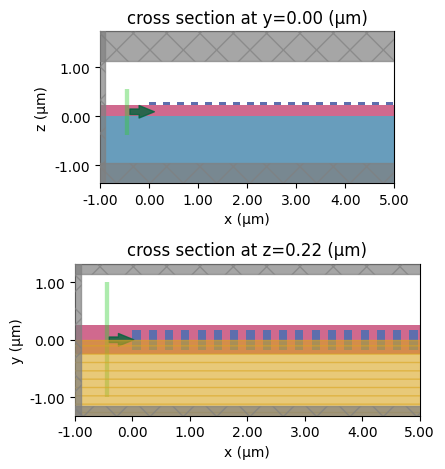

In [7]:
n = 150  # number of grating periods

# create simulations
sims = {"crystalline": make_sim(n, medium_cSb2Se3), "amorphous": make_sim(n, medium_aSb2Se3)}

# visualize the simulation setup
fig, ax = plt.subplots(2, 1, tight_layout=True)
sims["crystalline"].plot(y=0, ax=ax[0])
ax[0].set_xlim(-1, 5)

sims["crystalline"].plot(z=h_wg, ax=ax[1])
ax[1].set_xlim(-1, 5)
plt.show()

Run the simulations in parallel. 

In [8]:
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

Output()

14:41:46 CEST Started working on Batch containing 2 tasks.

14:41:49 CEST Maximum FlexCredit cost: 15.516 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

14:50:16 CEST Batch complete.

Output()

Check the cost of the simulations. We can see that the cost is substantial.

In [9]:
_ = batch.real_cost()

14:50:25 CEST Total billed flex credit cost: 9.370.

Plot the transmission spectra. We can see that in the crystalline phase, the Bragg wavelength is at 1500 nm as designed. In the amorphous phase, the Bragg wavelength is shifted to a shorter wavelength. Thus, this filter can effectively be tuned between these two spectra. 

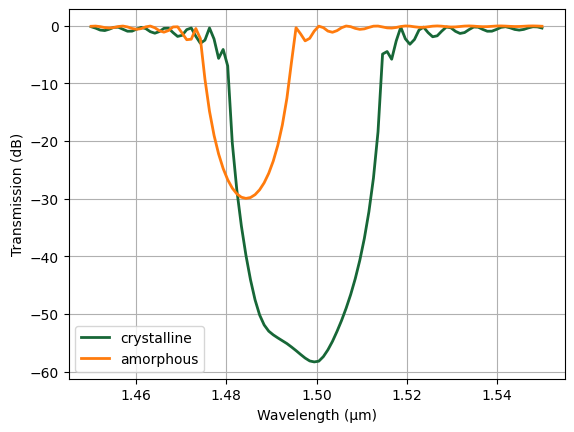

In [10]:
for phase in ["crystalline", "amorphous"]:
    amp = batch_results[phase]["mode"].amps.sel(mode_index=0, direction="+")
    T = np.abs(amp) ** 2  # transmission to the top waveguide

    plt.plot(ldas, 10 * np.log10(T), linewidth=2, label=phase)

plt.legend()
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (dB)")
plt.grid()
plt.show()

## EME Simulations

Now we demonstrate that EME can be an effective and low-cost tool in waveguide Bragg grating design. Tidy3D's EME solver supports periodic structures and can perform a sweep of the number of periods very quickly. Here we only simulate the amorphous phase but the crystalline phase can be simulated in the same way.

A few things to note regarding the EME simulation settings:

1. For the EME grid, we first use [EMEExplicitGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMEExplicitGrid.html) to define the unit cell that will be periodic and give it a name. This name will be used later to specify the periodicity sweep. Outside of the unit cell, we only need one grid and can use a [EMEUniformGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMEUniformGrid.html) since the waveguide is translationally invariant. The overall EME grid is then the composite of them. Here we will simulate 50, 150, and 1000 periods. We will compare the EME result to the FDTD result in the 150-period case to verify the accuracy of EME. 

2. We set `num_mode=1` in the mode specification and set `constraint="unitary"` in the [EMESimulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.EMESimulation.html). since we are primarily interested in the propagating mode instead of the radiation or leakage. Using too many modes can worsen results by introducing unstable radiative modes, causing mode mismatch between cells, or creating numerical instabilities.

In [11]:
# define the periodic grid for the grating
grating_grid = td.EMEExplicitGrid(
    mode_specs=[td.EMEModeSpec(num_modes=1)] * 2, boundaries=[p * ff], name="unit cell"
)

# define the grid for the waveguide
wg_grid = td.EMEUniformGrid(num_cells=1, mode_spec=td.EMEModeSpec(num_modes=1))

# define the overall EME grid as a composite
eme_grid_spec = td.EMECompositeGrid(
    subgrids=[wg_grid, grating_grid, wg_grid], subgrid_boundaries=[0, p]
)

# using the same in-plane grid spec as the previous FDTD simulations
grid_spec = td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0)

# we will simulate three cases with 50, 150, and 1000 grating periods
n_list = [50, 150, 1000]
sweep_spec = td.EMEPeriodicitySweep(num_reps=[{"unit cell": n} for n in n_list])

# define the EME simulation
eme_sim = td.EMESimulation(
    center=(p / 2, 0, h_wg - h_etch),
    size=(p + 2 * buffer, w_wg + 2 * buffer, h_wg + h_pcm + 2 * buffer),
    structures=make_structures(1, medium_aSb2Se3),
    grid_spec=grid_spec,
    eme_grid_spec=eme_grid_spec,
    freqs=freqs,
    axis=0,
    port_offsets=(buffer / 2, buffer / 2),
    sweep_spec=sweep_spec,
    store_port_modes=False,
    constraint="unitary",
    symmetry=(0, -1, 0),
)

Visualize the EME simulation.

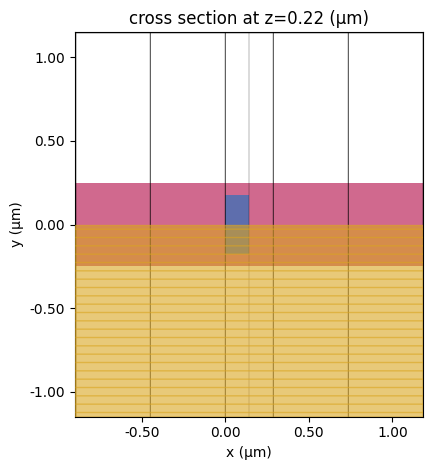

In [12]:
eme_sim.plot(z=h_wg)
plt.show()

Run the EME simulations with different numbers of periods. We can see that the cost is over an order of magnitude lower compared to FDTD, making it a very affordable option.

In [13]:
eme_sim_data = web.run(eme_sim, task_name="eme periodic")

14:50:27 CEST WARNING: Simulation has 1.00e+02 frequencies. Mode solving is     
              repeated at each frequency, so EME simulations with too many      
              frequencies can be slower and more expensive than FDTD            
              simulations. Consider using an 'EMEFreqSweep' instead for a faster
              approximate solution.                                             

              Created task 'eme periodic' with task_id                          
              'eme-45a7b3f0-aacd-49b3-9bc9-b91142c49721' and task_type 'EME'.

              Tidy3D's EME solver is currently in the beta stage. Cost of EME   
              simulations is subject to change in the future.

Output()

14:50:30 CEST Maximum FlexCredit cost: 0.314. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

14:50:31 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

14:50:36 CEST starting up solver

              running solver

Output()

14:52:59 CEST status = success

Output()

14:53:00 CEST loading simulation from simulation_data.hdf5

Plot the transmission of the EME simulations. As expected. the extinction ratio is increasing with the number of periods. 

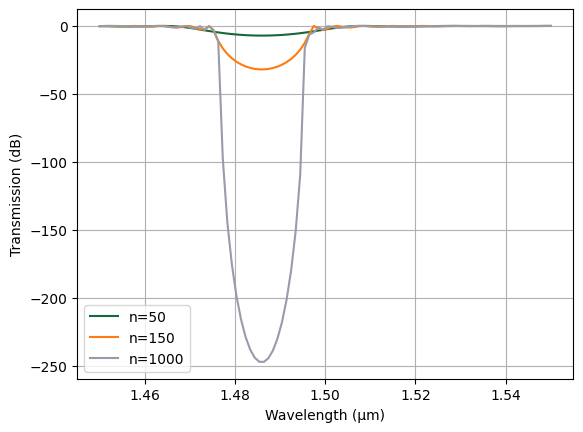

In [14]:
for i, n in enumerate(n_list):
    # extract transmission
    T = (
        eme_sim_data.smatrix.S21.isel(
            sweep_index=i, mode_index_out=0, mode_index_in=0
        ).abs.squeeze()
        ** 2
    )

    # plot the spectrum
    plt.plot(ldas, 10 * np.log10(T), label=f"n={n}")

plt.legend()
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (dB)")
plt.grid()
plt.show()

Compare the EME result with the previous FDTD result. They match very well, validating the efficacy of the EME method in modeling waveguide Bragg gratings. 

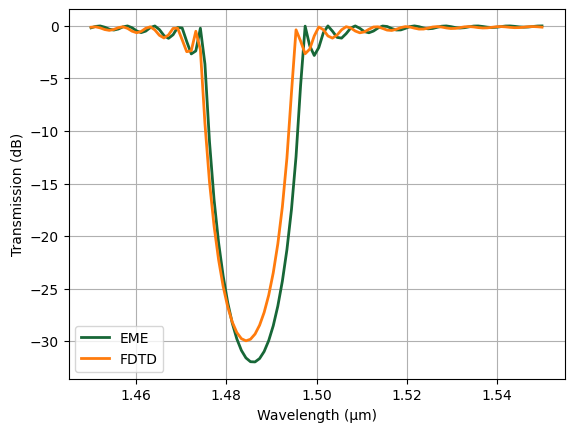

In [15]:
T = (
    eme_sim_data.smatrix.S21.isel(sweep_index=1, mode_index_out=0, mode_index_in=0).abs.squeeze()
    ** 2
)

plt.plot(ldas, 10 * np.log10(T), linewidth=2, label="EME")

amp = batch_results["amorphous"]["mode"].amps.sel(mode_index=0, direction="+")
T = np.abs(amp) ** 2  # transmission to the top waveguide

plt.plot(ldas, 10 * np.log10(T), linewidth=2, label="FDTD")

plt.legend()
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission (dB)")
plt.grid()
plt.show()
plt.show()

## Final Remarks

EME offers a powerful and efficient method for simulating long mode propagation problems including those with periodic features like Bragg gratings. By analytically solving for the modes within each section and propagating them through the structure, EME significantly reduces computational time and FlexCredit cost compared to full 3D FDTD simulations—especially for long devices. This makes EME an ideal tool for rapid design iteration and parameter sweeps. However, it is recommended to validate key results with rigorous FDTD simulations to ensure accuracy, particularly in complex or highly non-uniform structures.